<a href="https://colab.research.google.com/github/cstecker/politicsRLab/blob/main/Ja%2C%20wen%20w%C3%A4hlen%20Sie%20denn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Ja, wen wählen Sie denn?**

### **Setup**

**Alle Befehle bzw. Code-Schnipsel können Sie mit *Strg+Enter* oder durch das klicken des Play-Buttons passagenweise ausführen.** Darunter sehen Sie dann jeweils welches Ergebnis die jeweiligen Zeilen produzieren.
Sie können die Zeilen auch verändern und schauen, wie sich der Code verändert.

Wir laden zunächst die Library mit den Befehlen, die wir bei der Analyse benötigen.

In [43]:
library(tidyverse)
library(nnet)
library(broom)

Nun laden wir uns den Datensatz zur Vorlesungsumfrage, mit dem wir weiter arbeiten wollen. (Der aufbereitete Datensatz wird auf github bereitgestellt. Die Details hierzu müssen uns erst einmal nicht weiter kümmern).

In [ ]:
# Datensatz herunterladen -------------------------------------------------------------
download.file("https://github.com/cstecker/politicsRLab/blob/2d616affde737c631224f6461e18bdafdfd387f0/data/gles_for_app.rds?raw=TRUE", "gles_for_app.rds")

In [ ]:
# Datensatz in die Analyseplattform laden
gles <- readRDS("gles_for_app.rds")

Wir verschaffen uns nun einen ersten Blick auf den Datensatz, indem wir mit ```glimpse``` eine Auflistung aller Variablen mit weiteren Informationen erzeugen.

In [ ]:
glimpse(gles)

Rows: 3,431
Columns: 17
$ vote2nd           <fct> spd, fdp, gru, spd, cdu, cdu, spd, gru, gru, cdu, gr…
$ geschlecht        <fct> weiblich, maennlich, weiblich, maennlich, weiblich, …
$ age               <dbl> 27, 22, 32, 40, 59, 58, 54, 59, 56, 70, 75, 77, 85, …
$ schulbildung      <fct> "Realschulabschluss, Mittlere Reife, Fachschulreife …
$ satisdemo         <int> 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 4, 3, 3, 2, 2, 2…
$ konfession        <fct> keiner Religionsgemeinschaft, der evangelischen Kirc…
$ lire_self         <dbl> 6, 7, 4, 3, 1, 9, 2, 4, 6, 7, 4, 4, 10, NA, 7, 11, 7…
$ econ_self         <dbl> 11, NA, 4, 3, 7, 7, 5, 4, 6, 7, 3, 6, 7, 9, NA, 1, 7…
$ immi_self         <dbl> 9, NA, 3, 4, 8, 9, 5, 2, 4, 4, 2, 10, 8, 11, 6, 11, …
$ klima_self        <dbl> 5, 4, 1, 1, 1, 7, 1, 1, 1, 4, 1, 8, 8, 5, 5, 1, 5, 3…
$ pref_assimilation <int> 4, 4, 3, 3, 4, 4, 4, 4, 2, 4, 3, 5, 2, 4, 5, 5, 3, 4…
$ pref_genderquote  <int> 2, 5, 2, 2, 3, 3, 2, 5, 1, 5, 2, 3, 4, 3, 4, 1, 1, 3…
$ pref_stateecon

Sodann wollen wir uns auch noch die vertraute Excel-Ansicht anschauen.

In [ ]:
gles %>%
  # wir ziehen eine Zufallsstichprobe von 10
  sample_n(10) %>%
  # wir wählen uns wenige Variablen aus, die wir ansehen wollen
  select(geschlecht, age, schulbildung, vote2nd) %>%
  View()

geschlecht,age,schulbildung,vote2nd
<fct>,<dbl>,<fct>,<fct>
weiblich,58,"Hauptschulabschluss, Volksschulabschluss, Abschluss der Polytechnischen Oberschule 8. oder 9. Klasse",NA
weiblich,58,NA,oth
weiblich,55,Abitur bzw. erweiterte Oberschule mit Abschluss 12. Klasse (Hochschulreife),gru
weiblich,47,Abitur bzw. erweiterte Oberschule mit Abschluss 12. Klasse (Hochschulreife),cdu
weiblich,55,Abitur bzw. erweiterte Oberschule mit Abschluss 12. Klasse (Hochschulreife),gru
weiblich,48,Abitur bzw. erweiterte Oberschule mit Abschluss 12. Klasse (Hochschulreife),cdu
maennlich,57,"Realschulabschluss, Mittlere Reife, Fachschulreife oder Abschluss der Polytechnischen Oberschule 10. Klasse",cdu
maennlich,86,Abitur bzw. erweiterte Oberschule mit Abschluss 12. Klasse (Hochschulreife),spd
maennlich,57,"Hauptschulabschluss, Volksschulabschluss, Abschluss der Polytechnischen Oberschule 8. oder 9. Klasse",oth


### **Wie sind die Präferenzen der Wählerinnen verteilt?**


Wir möchten uns nun anschauen, wie die Präferenzen der Wählerschaft verteilt sind. Dazu nehmen wir das Umverteilungs-Thema. Die Frage dazu im Survey lautete:  *Wie ist Ihre Meinung zum Thema Steuern und sozialstaatliche Leistungen?* und antworten konnte man darauf zwischen *(1) mehr sozialstaatliche Leistungen und mehr Steuern* <--> *weniger Steuern und weniger sozialstaatliche Leistungen (11)*.

Beginnen wir mit der einfachen Auszählung, "mutaten" uns aber noch die Prozente dazu.


In [21]:
gles %>%
  # wir werfen alle Fälle raus, die bei econ_self missing sind
  drop_na(econ_self) %>%
  # wir zählen die absoluten Häufigkeiten
  count(econ_self) %>%
  # wir berechnen die Prozentanteile der Antworten
  mutate(perc = round(n/sum(n)*100, digits =2))

econ_self,n,perc
<dbl>,<int>,<dbl>
1,112,3.34
2,98,2.93
3,223,6.66
4,319,9.52
5,365,10.90
6,867,25.88
7,515,15.37
8,322,9.61
9,250,7.46


Wir sind ja Sozialwissenschaftler und starren lieber auf Bilder als auf Zahlen. Daher:

Warning message:
“Removed 81 rows containing non-finite values (`stat_density()`).”


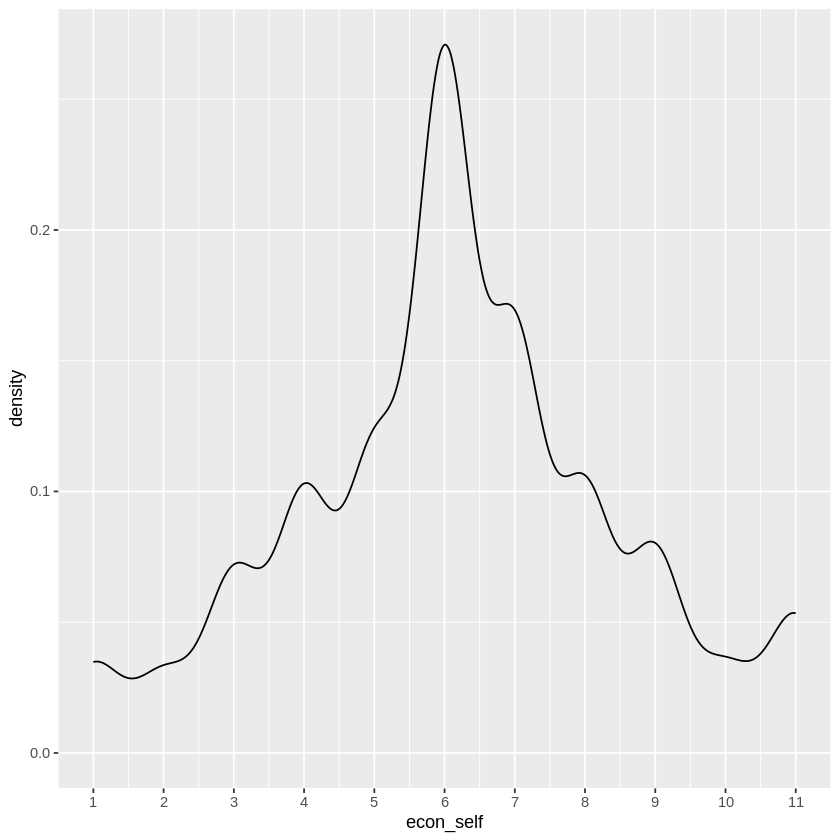

In [24]:
gles %>%
  ggplot(aes(x = econ_self)) +
  geom_density() +
  scale_x_continuous(limits = c(1, 11),
                     labels = 1:11,
                     breaks = 1:11)

Versuchen Sie doch das ganze mal mit klima_self!

Parteien bilden sich ja häufig um Wählergruppen mit gegensätzlichen Präferenzen. D.h. es sollte einen Zusammenhang zwischen politischen Präferenzen und Parteiwahl bestehen. Let's have a look!

Warning message:
“Removed 46 rows containing non-finite values (`stat_density()`).”


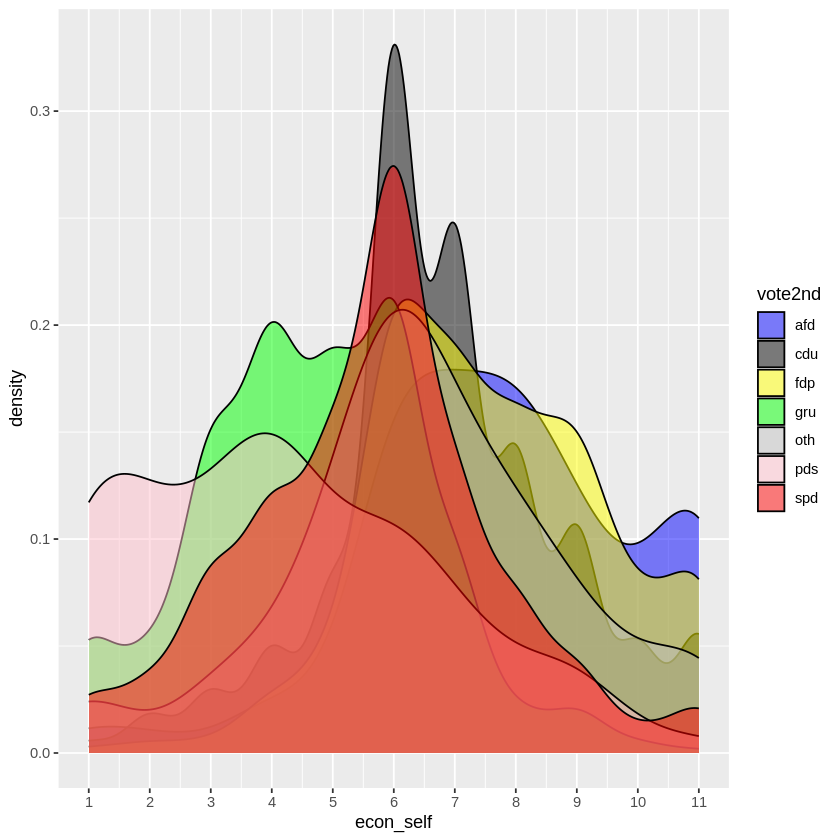

In [26]:
# Verwende den 'gles' Datensatz
gles %>%
# Entferne Zeilen mit fehlenden Werten in 'vote2nd' und 'klima_self'
  drop_na(vote2nd, klima_self) %>%
# Erstelle ein Dichtediagramm mit 'econ_self' auf der X-Achse und Gruppierung nach 'vote2nd'
  ggplot(aes(x = econ_self, fill = vote2nd)) +
# Zeichne Dichtelinien mit halber Transparenz
  geom_density(alpha = .5) +
# Setze die Grenzen der X-Achse von 1 bis 11, beschrifte und platziere Achsenabschnitte
  scale_x_continuous(limits = c(1, 11),
                     labels = 1:11,
                     breaks = 1:11) +
# Manuelle Farbzuweisung für die unterschiedlichen Kategorien von 'vote2nd'
  scale_fill_manual(
    values = c("blue", "black", "yellow", "green", "grey", "pink", "red")
  )


Bei welchem Thema schält sich denn die AfD-Unterstützerschaft am deutlichsten heraus?

Nun wollen wir uns Präferenzen einmal zweidimensional anschauen. Sahra Wagenknecht hatte ja die Vermutung, dass es eine relevante Zahl linksautoritärer Wählerinnen und Wähler gibt, die bisher kein politische Angebot erhalten. Dies schauen wir uns mit der folgenden Abbildung an.

Warning message:
“Removed 266 rows containing missing values (`geom_point()`).”


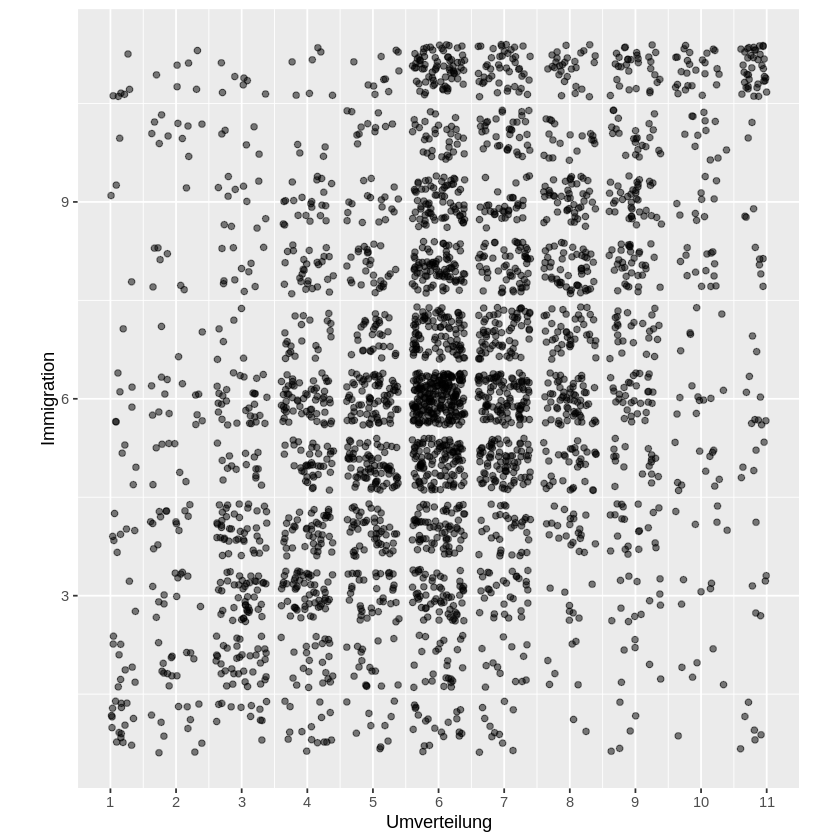

In [32]:
gles %>% # Verwende den 'gles' Datensatz
  ggplot(aes(x = econ_self, y = immi_self)) + # Erstelle ein Diagramm mit 'econ_self' auf der X- und 'immi_self' auf der Y-Achse
  geom_jitter(alpha = .5) +  # Zeichne Punkte mit leichter zufälliger Verschiebung und halber Transparenz
  scale_x_continuous(limits = c(1, 11), # Setze die Grenzen der X-Achse von 1 bis 11
                     labels = 1:11, # Beschrifte die X-Achse mit Werten von 1 bis 11
                     breaks = 1:11) + # Platziere Achsenabschnitte bei jedem ganzen Wert von 1 bis 11
                       # Manuelle Farbzuweisung für die unterschiedlichen Kategorien von 'vote2nd'
  labs(x = "Umverteilung", y = "Immigration") + # Benenne die Achsen: X als 'Umverteilung', Y als 'Immigration'
  coord_fixed() # Verwende das gleiche Maßstabverhältnis für X- und Y-Achse für ein proportionales Diagramm


###**Wie können wir das Wahlverhalten erklären?**

Das Wahlverhalten erklären wir u.a. mit Blick auf soziodemographische Faktoren und politische Einstellungen. Zum Beispiel könnte es sein, dass Frauen anders wählen als Männer.

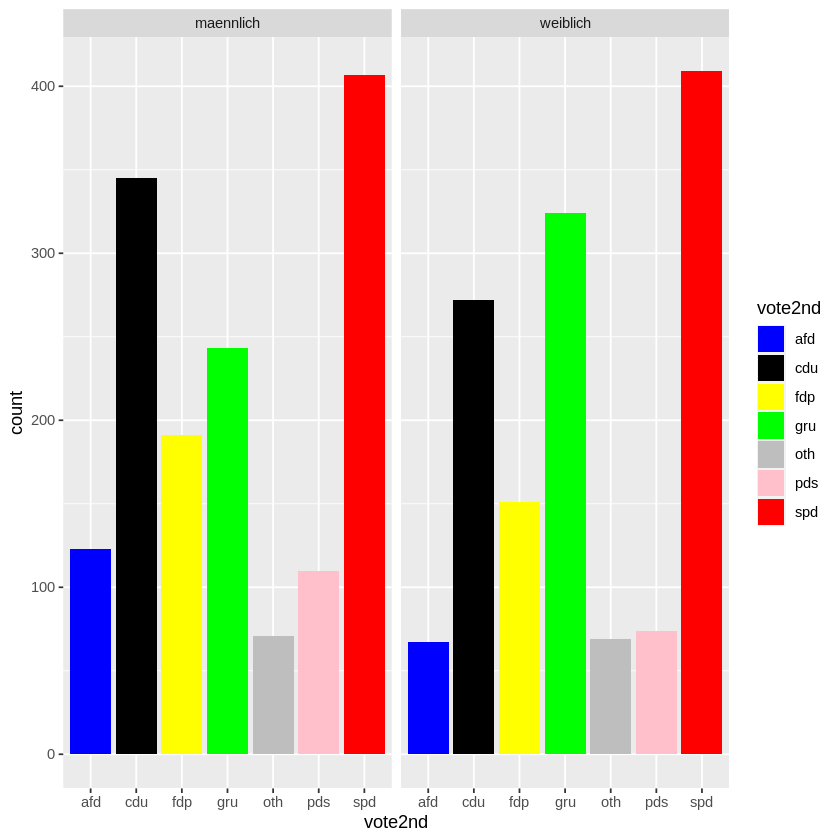

In [34]:
gles %>%
  drop_na(geschlecht, vote2nd) %>%
  ggplot(aes(x = vote2nd, fill = vote2nd)) +
  geom_bar() +
  # Manuelle Farbzuweisung für die unterschiedlichen Kategorien von 'vote2nd'
  scale_fill_manual(
    values = c("blue", "black", "yellow", "green", "grey", "pink", "red")
  ) +
  facet_wrap(~geschlecht)

Auch dürfte es so sein, dass sich die AfD-Wählerschaft bei bestimmten Theman von den Wählern anderer Parteien abhebt.

Warning message:
“Removed 30 rows containing non-finite values (`stat_count()`).”
Warning message:
“Removed 14 rows containing missing values (`geom_bar()`).”


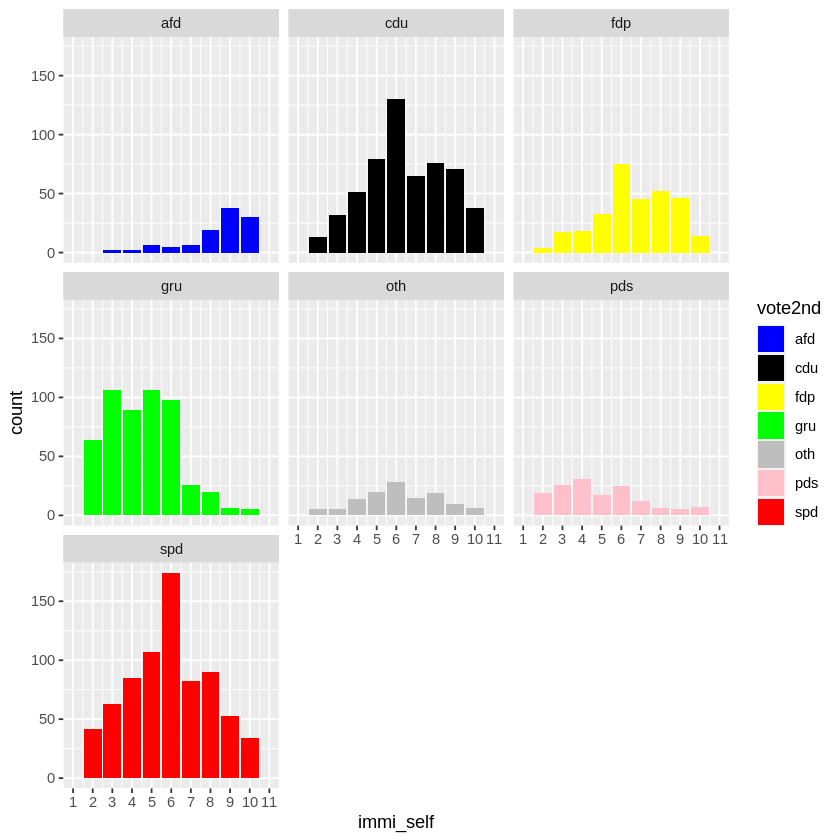

In [36]:
gles %>%
  drop_na(vote2nd) %>%
  ggplot(aes(x = immi_self, fill = vote2nd)) +
  geom_bar() +
  # Manuelle Farbzuweisung für die unterschiedlichen Kategorien von 'vote2nd'
  scale_x_continuous(limits = c(1, 11),
                     labels = 1:11,
                     breaks = 1:11)  +
  scale_fill_manual(
    values = c("blue", "black", "yellow", "green", "grey", "pink", "red")
  ) +
  facet_wrap(~vote2nd)

Nun wollen wir verstehen, wie sehr das Geschlecht oder meine Einstellung gegenüber Migration auf mein Wahlverhalten wirkt. Dabei haben wir aber das Problem, dass wir den Einfluss einzelner Variablen isolieren müssen. Es könnte ja sein, dass es gar nicht Männer an sich sind, die häufiger AfD wählen, vielleicht habe ich einfach mehr alte Männer als Frauen und das Alter ist die eigentlich zentrale Erklärungsvariable.
Um für solche Einflüsse zu kontrollieren, berechnen wir multivariate Modelle.
Berechnen wir also mal ein Modell, in dem das Wahlverhalten erklärt wird mit verschiedenen Variablen (Geschlecht, alter, Schulbildung, etc.).
Die Details müssen uns hier aber nicht beschäftigen.

In [37]:
multinomial_model <- multinom(
  vote2nd ~ geschlecht + age + schulbildung + satisdemo + konfession +
    econ_self + immi_self + klima_self,
  data = gles,
  model = TRUE
)

# weights:  133 (108 variable)
initial  value 4872.559013 
iter  10 value 4111.729169
iter  20 value 3793.911738
iter  30 value 3617.917109
iter  40 value 3421.925996
iter  50 value 3334.240800
iter  60 value 3313.822870
iter  70 value 3308.841906
iter  80 value 3307.873516
iter  90 value 3307.620168
iter 100 value 3307.470081
final  value 3307.470081 
stopped after 100 iterations


Das Modell schätzt anhand aller Befragten die Einflüsse der Variablen auf das Wahlverhalten. Wir können uns z. B. ansehen, wie sehr die Wahlwahrscheinlichkeit für die verschiedenen Parteien in Abhängigkeit der politischen Einstellungen steigt.